In [9]:
import numpy as np
import torch
import sys
sys.path.append('../')
from model import Model
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [10]:
N = 1000

In [11]:
model_eigenvectors = torch.jit.load("../models/eigenvectors_cosine_similarity_skip1_batch64_modelstandard_actelu.pt")
model_simulation = torch.jit.load("../models/simulation_cosine_similarity_skip10_batch64_modelstandard.pt")

In [12]:
grid_size_x = 34
grid_size_y = 34
dx = 1 / (grid_size_x)
dy = 1 / (grid_size_y)
dx2 = dx ** 2
dy2 = dy ** 2

# generate Matrix A which is the discretized Laplacian in 2D
A = np.zeros((grid_size_x * grid_size_y, grid_size_x * grid_size_y))
for i in range(grid_size_x):
    for j in range(grid_size_y):
        row = i * grid_size_y + j
        A[row, row] = -2 * (1 / dx2 + 1 / dy2)
        if i > 0:
            A[row, row - grid_size_y] = 1 / dx2
        if i < grid_size_x - 1:
            A[row, row + grid_size_y] = 1 / dx2
        if j > 0:
            A[row, row - 1] = 1 / dy2
        if j < grid_size_y - 1:
            A[row, row + 1] = 1 / dy2

A_inverse = np.linalg.inv(A)

In [13]:
input_vectors = []
real_output_vectors = []
pred_eig_output_vectors = []
pred_sim_output_vectors = []
A_inverse_output_vectors = []
for i in range(N):
    input_vector = np.loadtxt(f"../data/simulation_data/res_{i}.dat")
    real_output_vector = np.loadtxt(f"../data/simulation_data/e_{i}.dat")
    input_vector = torch.tensor(input_vector).float().unsqueeze(0).unsqueeze(0).to('cuda')
    real_output_vector = torch.tensor(real_output_vector).float().unsqueeze(0).to('cuda')
    pred_eig_output_vectors.append(model_eigenvectors(input_vector).cpu().detach().numpy().flatten())
    pred_sim_output_vectors.append(model_simulation(input_vector).cpu().detach().numpy().flatten())
    input_vectors.append(input_vector.cpu().detach().numpy().flatten())
    real_output_vectors.append(real_output_vector.cpu().detach().numpy().flatten())
    A_inverse_output_vectors.append(np.dot(A_inverse, input_vector.cpu().detach().numpy().flatten()))

In [14]:
# Calculate the cosine similarity
cosine_similarities_pred_eig = []
cosine_similarities_pred_sim = []
cosine_similarities_A_inverse = []
for i in range(N):
    cosine_similarity_pred_eig = np.dot(real_output_vectors[i], pred_eig_output_vectors[i]) / (np.linalg.norm(real_output_vectors[i]) * np.linalg.norm(pred_eig_output_vectors[i]))
    cosine_similarities_pred_eig.append(cosine_similarity_pred_eig)
    cosine_similarity_pred_sim = np.dot(real_output_vectors[i], pred_sim_output_vectors[i]) / (np.linalg.norm(real_output_vectors[i]) * np.linalg.norm(pred_sim_output_vectors[i]))
    cosine_similarities_pred_sim.append(cosine_similarity_pred_sim)
    cosine_similarity_A_inverse = np.dot(real_output_vectors[i], A_inverse_output_vectors[i]) / (np.linalg.norm(real_output_vectors[i]) * np.linalg.norm(A_inverse_output_vectors[i]))
    cosine_similarities_A_inverse.append(cosine_similarity_A_inverse)

Text(0.5, 1.0, 'Cosine similarity between yielded outputs with simulation data as input')

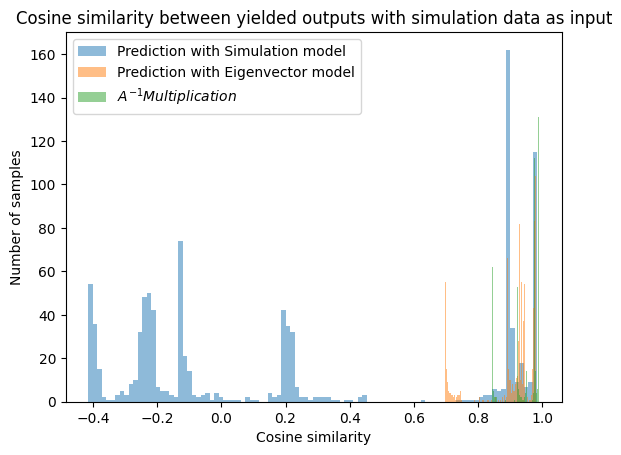

In [17]:
# Plot the cosine similarities as histogram

plt.hist(cosine_similarities_pred_sim, bins=100, alpha=0.5, label='Prediction with Simulation model')
plt.hist(cosine_similarities_pred_eig, bins=100, alpha=0.5, label='Prediction with Eigenvector model')
plt.hist(cosine_similarities_A_inverse, bins=100, alpha=0.5, label="$A^{-1} Multiplication$")
plt.legend(loc='upper left')
plt.xlabel('Cosine similarity')
plt.ylabel('Number of samples')
plt.title('Cosine similarity between yielded outputs with simulation data as input')

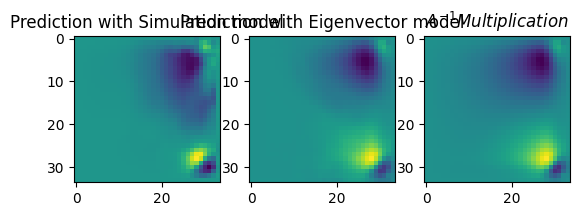

In [33]:
# plot imshow of pred_sim_output_vectors, pred_eig_output_vectors, A_inverse_output_vectors number 0, side by side
fig, axs = plt.subplots(1, 3)
i = 100
axs[0].imshow(pred_sim_output_vectors[i].reshape(grid_size_x, grid_size_y))
axs[0].set_title('Prediction with Simulation model')
axs[1].imshow(pred_eig_output_vectors[i].reshape(grid_size_x, grid_size_y))
axs[1].set_title('Prediction with Eigenvector model')
axs[2].imshow(A_inverse_output_vectors[i].reshape(grid_size_x, grid_size_y))
axs[2].set_title('$A^{-1} Multiplication$')
plt.show()
